In [1]:
print("Hello World")

Hello World


In [2]:
import getpass 
import os

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("GROQ_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [4]:
from typing import Annotated


from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=3)

repl = PythonREPL()


In [6]:
tavily_tool.invoke("What is the GDP of the UK?")

[{'url': 'https://www.statista.com/topics/3795/gdp-of-the-uk/',
  'content': 'Monthly growth of gross domestic product in the United Kingdom from January 2019 to November 2023\nContribution to GDP growth in the UK 2023, by sector\nContribution to gross domestic product growth in the United Kingdom in January 2023, by sector\nGDP growth rate in the UK 1999-2021, by country\nAnnual growth rates of gross domestic product in the United Kingdom from 1999 to 2021, by country\nGDP growth rate in the UK 2021, by region\nAnnual growth rates of gross domestic product in the United Kingdom in 2021, by region\nGDP growth of Scotland 2021, by local area\nAnnual growth rates of gross domestic product in Scotland in 2021, by local (ITL 3) area\nGDP growth of Wales 2021, by local area\nAnnual growth rates of gross domestic product in Wales in 2021, by local (ITL 3) area\nGDP growth of Northern Ireland 2021, by local area\nAnnual growth rates of gross domestic product in Northern Ireland in 2021, by lo

In [7]:
repl

PythonREPL(globals={}, locals={})

In [9]:
@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]) -> str:
    """Use this to execute python code and do math. If you want to see the output of a value,
you should print it out with `print(...)`. This is visible to the user."""
    try:
        return repl.invoke(code)
    except Exception as e:
        return f"Error: {str(e)}"


In [28]:
#### Create the agent supervisor


from typing import Literal
from typing_extensions import TypedDict

from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, END
from langgraph.types import Command

members = ['researcher', 'coder']

options = members + ["FINISH"]


system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    next: Literal[*options]


llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)
class State(MessagesState):
    next: str = "supervisor"  # Add default value

def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ]
    # Convert tuple messages to proper format
    for role, content in state["messages"]:
        messages.append({"role": role, "content": content})
    
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})


In [29]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()




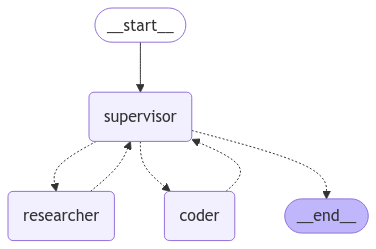

In [30]:


from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

ValueError: too many values to unpack (expected 2)

In [60]:
# %%capture --no-stderr
!pip install -U langgraph langchain_community langchain_anthropic langchain_experimental


  Using cached langchain_experimental-0.3.4-py3-none-any.whl.metadata (1.7 kB)
  Using cached aiohttp-3.11.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached httpx_sse-0.4.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached pydantic_settings-2.7.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached aiohappyeyeballs-2.4.4-py3-none-any.whl.metadata (6.1 kB)
  Using cached propcache-0.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached yarl-1.18.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (69 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached jiter-0.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.2 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
  Using cached

In [61]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

In [62]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatGroq(model="llama-3.1-8b-instant")


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [63]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=(
        "You are a research assistant. Your ONLY tool is web search.\n"
        "When asked for calculations/math:\n"
        "1. Acknowledge you can't do calculations\n"
        "2. Suggest the coder agent can help with Python computations\n"
        "3. Provide any relevant contextual information from web search"
    )
)

def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

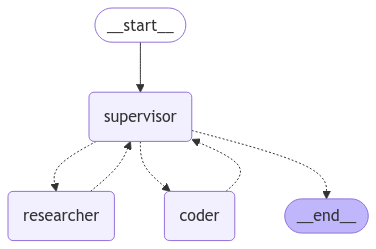

In [64]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [65]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:e697d283-ca9f-d080-14f3-83b7faa0ec06',), {'agent': {'messages': [AIMessage(content="I'm not able to perform mathematical calculations.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 298, 'total_tokens': 308, 'completion_time': 0.013333333, 'prompt_time': 0.025030468, 'queue_time': 0.020215285, 'total_time': 0.038363801}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'stop', 'logprobs': None}, id='run-1a5f4728-4aae-4847-8cef-658b4469933c-0', usage_metadata={'input_tokens': 298, 'output_tokens': 10, 'total_tokens': 308})]}})
----
((), {'researcher': {'messages': [HumanMessage(content="I'm not able to perform mathematical calculations.", additional_kwargs={}, response_metadata={}, name='researcher')]}})
----
((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:c9038c53-c55b-4b40-a400-39f2b221c2ac',), {'agent': {'me

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [67]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

In [72]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor managing a team with clear roles:\n"
    "1. Researcher (researcher): Uses web search ONLY for factual queries. Cannot do math.\n" 
    "2. Coder (coder): Executes Python code for calculations and data analysis.\n\n"
    "Routing Rules:\n"
    "- Route math/calculation requests to coder immediately\n"
    "- Route general knowledge questions to researcher\n"
    "- If researcher cannot answer, route to coder\n"
    "- FINISH when question is fully answered"
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)

class State(MessagesState):
    next: str = "supervisor"  # Add default value to prevent KeyError


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    # Build messages list first
    messages = [
        {"role": "system", "content": system_prompt},
    ] + [
        {"role": "user", "content": content} if isinstance(msg, tuple)
        else {"role": "assistant", "content": msg.content, "name": msg.name}
        for msg in state["messages"]
    ]
    
    # Now add loop detection using properly constructed messages
    if len(messages) > 4:  # Check last 3 actual interactions (skip system prompt)
        last_responses = [
            msg["content"] 
            for msg in messages[-3:] 
            if msg.get("name") == "researcher"
        ]
        if len(last_responses) >= 2 and all("can't" in resp.lower() for resp in last_responses):
            return Command(goto="coder", update={"next": "coder"})
    
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    
    # Force transition logic using the properly constructed messages
    if goto == "researcher" and any(
        msg.get("name") == "researcher" 
        for msg in messages[-2:]
    ):
        goto = "coder"
    
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [73]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=(
        "You are a research assistant. Your ONLY tool is web search.\n"
        "When asked for calculations/math:\n"
        "1. Acknowledge you can't do calculations\n"
        "2. Suggest the coder agent can help with Python computations\n"
        "3. Provide any relevant contextual information from web search"
    )
)

from langchain_core.messages import AIMessage  # Add this import

def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                AIMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                AIMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

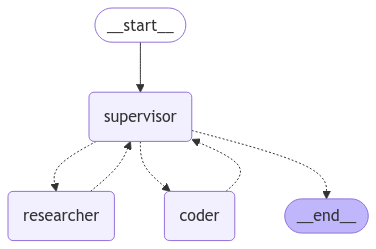

In [74]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [75]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, 
    subgraphs=True,
    config={"recursion_limit": 100}  # Temporary safety while testing
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'coder'}})
----


Python REPL can execute arbitrary code. Use with caution.


(('coder:ffe0125e-bb7e-9e4c-984c-2d8480fdf307',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_54rb', 'function': {'arguments': '{"code": "import math; print(math.sqrt(42))"}', 'name': 'python_repl_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 302, 'total_tokens': 327, 'completion_time': 0.033333333, 'prompt_time': 0.024703719, 'queue_time': 0.018201501000000002, 'total_time': 0.058037052}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9cb648b966', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5eaf578e-4180-4b84-819a-a3efbf286c41-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math; print(math.sqrt(42))'}, 'id': 'call_54rb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 302, 'output_tokens': 25, 'total_tokens': 327})]}})
----
(('coder:ffe0125e-bb7e-9e4c-984c-2d8480fdf307',), {'tools': {'messages': [ToolMessage(content

GraphRecursionError: Recursion limit of 100 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT